## Adversarial Debiasing


In [15]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import keras as ke
import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model
create_gif = True
import tensorflow as tf

In [17]:
#load dataset
train= pd.read_csv('Train_v2.csv')
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def load_data(data, s_attr):
    X= data.drop(['bank_account','uniqueid'],axis=1)
    Y= data['bank_account']
    Y=pd.Series([0 if x=='No' else 1 for x in Y])
    categorical_feature_mask = X.dtypes==object
    categorical_cols = X.columns[categorical_feature_mask].tolist()
    X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))
    Z = X.loc[:, s_attr]
    X= X.drop([s_attr],axis=1)
    return X, Y, Z

In [7]:
#load data
X, Y, Z = load_data(train, 'gender_of_respondent')

In [8]:
# split data
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, Y, Z, test_size=0.3, 
                                                                     stratify=Y, random_state=17)

In [25]:
# function that generates the plot of the probability distribution for protected and unprotected groups.
# It takes in predictions and the sensitive attributes.
def plot(y_pred,Z_test, iteration=None, val_metrics=None, p_rules=None, dp=None,fname=None):
    fig=plt.figure(figsize=[10,10])
    y0val=[]
    y1val=[]
    for (i,j) in zip(y_pred,Z_test):
        if j==0:
            y0val.append(i)
        else:
            y1val.append(i)
    ax = sns.distplot(y0val, hist=False, kde_kws={'shade': True,},
                    norm_hist=True,
                      label='Female')
    ax = sns.distplot(y1val, hist=False, kde_kws={'shade': True,},
                      norm_hist=True,
                          label='Male')
    ax.set_ylabel('prediction distribution')
    ax.set_xlabel(r'P{Bank account=Yes}')
    if iteration:
        fig.text(1.0, 0.9, f"Training iteration #{iteration}", fontsize='16')
    if val_metrics is not None:
        fig.text(1.0, 0.65, '\n'.join(["Prediction performance:",
                                       f"- ROC AUC: {val_metrics['ROC AUC']:.2f}",
                                       f"- Accuracy: {val_metrics['Accuracy']:.1f}"]),
                 fontsize='16')
    if p_rules is not None:
        fig.text(1.0, 0.4, '\n'.join(["Satisfied disparate Impact:"] +
                                     [f"- {attr}: {p_rules[attr]:.0f}-rule" 
                                      for attr in p_rules.keys()]), 
                 fontsize='16')
        fig.tight_layout()
    if dp is not None:
        fig.text(1.0, 0.2, '\n'.join(["Disparate Mistreatment:"] +
                                     [f"- {attr}: {dp[attr]:.4f}" 
                                      for attr in dp.keys()]), 
                 fontsize='16')
        fig.tight_layout()
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')
    return fig

In [9]:
# neural network model on original data which takes the number of features as input and returns model
def nn_classifier(n_features):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    #to prevent overfitting
    dropout1 = Dropout(0.01)(dense1)
    dense2 = Dense(10, activation='relu')(dropout1)
    outputs = Dense(1, activation='sigmoid')(dropout1)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# initialise NeuralNet Classifier
clf = nn_classifier(n_features=X_train.shape[1])

# train on train set
history = clf.fit(X_train.values, y_train.values, epochs=20, verbose=0)

In [10]:
# predict and set threshold
pred =clf.predict(X_test)
preds= np.array([round(i[0]) for i in pred])

In [11]:
y_pred = clf.predict(X_test)
pred= np.array([int(round(i[0])) for i in y_pred])
print(f"ROC AUC: {roc_auc_score(y_test, pred):.2f}")
print(f"Accuracy: {100*accuracy_score(y_test, pred):.1f}%")

ROC AUC: 0.62
Accuracy: 87.6%


In [19]:
# computing fairness metric for unfair classifier
F=Get_fair_metric('unfair',pred,y_test,Z_test)
A=pd.DataFrame([F])

In [21]:
#visualise
A

,model,Demographic Parity,Disparate Impact,Equalised_opportunity,Equalised_odds,Treatment equality,Predictive equality,Conditional Use Accuracy,Overall Use Accuracy
0,unfair,0.044682,0.66129,-0.05786,-0.019389,1.217391,0.019389,0.037458,-0.038471


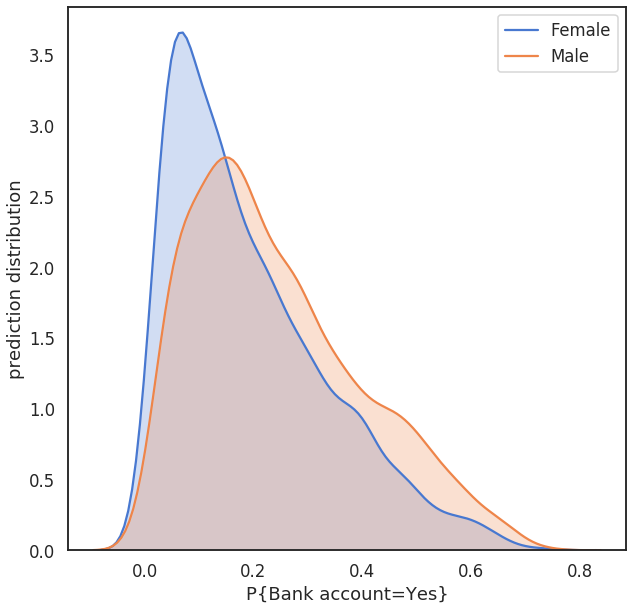

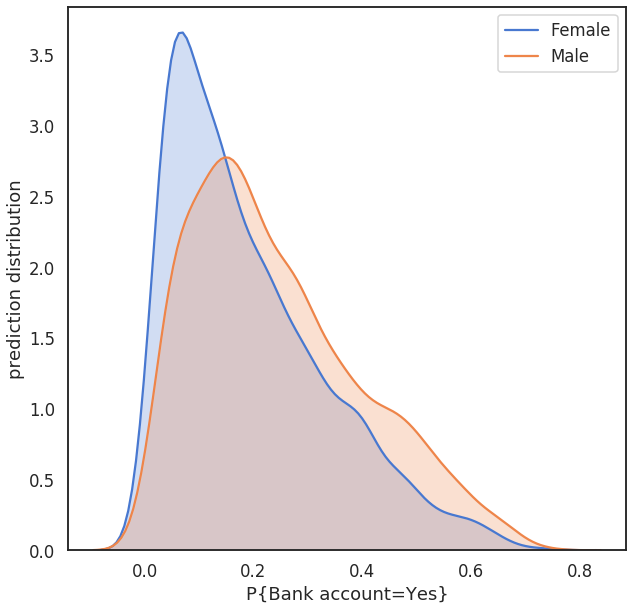

In [24]:
plot(y_pred,Z_test)

In [26]:
def DP_accuracy (y_hat,A, threshold=0.5):
#     A , y_hat = np.array(A) , y_hat.reshape(-1)
    y_z_1 = y_pred[A == 1] > threshold if threshold else y_pred[A == 1]
    y_z_0 = y_pred[A == 0] > threshold if threshold else y_pred[A == 0]
    accuracy=y_z_1.mean() - y_z_0.mean()
#     print('DP accuracy={0:.2f}'.format(accuracy))
    return accuracy

In [28]:
z_values=Z_test.values

In [29]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

In [30]:
p_rule(pred, Z_test)

47.10209575683586

In [85]:
# This class FairGAN takes in the the number of features, number of 
# sensitive attributes and and array of lambdas 
class FairGAN(object):
    
    def __init__(self, n_features, n_sensitive, lambdas):
        self.lambdas = lambdas
        
        clf_inputs = Input(shape=(n_features,))
        adv_inputs = Input(shape=(1,))
        clf_net = self._create_clf_net(clf_inputs)
        adv_net = self._create_adv_net(adv_inputs, n_sensitive)
        self._trainable_clf_net = self._make_trainable(clf_net)
        self._trainable_adv_net = self._make_trainable(adv_net)
        self._clf = self._compile_clf(clf_net)
        self._clf_w_adv = self._compile_clf_w_adv(clf_inputs, clf_net, adv_net)
        self._adv = self._compile_adv(clf_inputs, clf_net, adv_net, n_sensitive)
        self._val_metrics = None
        self._fairness_metrics = None     
        self.predict = self._clf.predict
        
    # Function to make network trainable
    def _make_trainable(self, net):
        def make_trainable(flag):
            net.trainable = flag
            for layer in net.layers:
                layer.trainable = flag
        return make_trainable
        
    # creating classifier network using function that returns model for pretraining
    def _create_clf_net(self, inputs):
        dense1 = Dense(32, activation='relu')(inputs)
        dropout1 = Dropout(0.01)(dense1)
        dense2 = Dense(12, activation='relu')(dropout1)
        outputs = Dense(1, activation='sigmoid', name='y')(dense2)
        return Model(inputs=[inputs], outputs=[outputs])
        
    # creating adversary network using function that returns model for pretraining
    def _create_adv_net(self, inputs, n_sensitive):
        dense1 = Dense(64, activation='relu')(inputs)
        dropout1 = Dropout(0.001)(dense1)
        dense2 = Dense(32, activation='relu')(dropout1)
        outputs = [Dense(1, activation='sigmoid')(dense2) for _ in range(n_sensitive)]
        return Model(inputs=[inputs], outputs=outputs)

    # compiling the classifier network
    def _compile_clf(self, clf_net):
        clf = clf_net
        self._trainable_clf_net(True)
        clf.compile(loss='binary_crossentropy', optimizer='adam')
        return clf
        
        
    # compiling the classifier and adversary network
    def _compile_clf_w_adv(self, inputs, clf_net, adv_net):
        clf_w_adv = Model(inputs=[inputs], outputs=[clf_net(inputs)]+[adv_net(clf_net(inputs))])
        self._trainable_clf_net(True)
        self._trainable_adv_net(False)
        loss_weights = [1.]+[-lambda_param for lambda_param in self.lambdas]
        clf_w_adv.compile(loss=['binary_crossentropy']*(len(loss_weights)), 
                          loss_weights=loss_weights,
                          optimizer='adam')
        return clf_w_adv

    # compiling the adversary network
    def _compile_adv(self, inputs, clf_net, adv_net, n_sensitive):
        adv = Model(inputs=[inputs], outputs=adv_net(clf_net(inputs)))
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        adv.compile(loss=['binary_crossentropy']*n_sensitive, optimizer='adam')
        return adv

    # computing the class weights for the dataset
    def _compute_class_weights(self, data_set):
        class_values = [0, 1]
        class_weights = []
        if len(data_set.shape) == 1:
            balanced_weights = compute_class_weight('balanced', class_values, data_set)
            class_weights.append(dict(zip(class_values, balanced_weights)))
        else:
            n_attr =  data_set.shape[1]
            for attr_idx in range(n_attr):
                balanced_weights = compute_class_weight('balanced', class_values,
                                                        np.array(data_set)[:,attr_idx])
                class_weights.append(dict(zip(class_values, balanced_weights)))
        return class_weights
    
    # computing the class weights for the target
    def _compute_target_class_weights(self, y):
        class_values  = [0,1]
        balanced_weights =  compute_class_weight('balanced', class_values, y)
        class_weights = {'y': dict(zip(class_values, balanced_weights))}
        return class_weights
        
    # pretrain both classifier and adversary
    def pretrain(self, x, y, z, epochs=10, verbose=0):
        self._trainable_clf_net(True)
        self._clf.fit(x.values, y.values, epochs=epochs, verbose=verbose)
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        class_weight_adv = self._compute_class_weights(z)
        self._adv.fit(x.values, np.hsplit(z.values, 1), class_weight=class_weight_adv, 
                      epochs=epochs, verbose=verbose)
       
    # fit
    def fit(self, x, y, z, validation_data=None, T_iter=250, batch_size=128,save_figs=True):
        n_sensitive = 1
        if validation_data is not None:
            x_val, y_val, z_val = validation_data

        class_weight_adv = self._compute_class_weights(z)
        class_weight_clf_w_adv = [{0:1., 1:1.}]+class_weight_adv
        self._val_metrics = pd.DataFrame()
        self._vall_metrics = pd.DataFrame()
        self._fairness_metrics = pd.DataFrame()  
        for idx in range(T_iter):
            if validation_data is not None:
                y_pred1 = pd.Series(self._clf.predict(x_val).ravel(), index=y_val.index)
                y_pred = self._clf.predict(x_val)
                pred= np.array([int(round(i[0])) for i in y_pred])
                self._val_metrics.loc[idx, 'ROC AUC'] = roc_auc_score(y_val, pred)
                self._val_metrics.loc[idx, 'Accuracy'] = (accuracy_score(y_val, pred)*100)
                self._vall_metrics.loc[idx, 'gender_of_respondent'] = DP_accuracy(y_pred1,z_val)
                self._fairness_metrics.loc[idx, 'gender_of_respondent'] = p_rule(y_pred1,z_val)
            display.clear_output(wait=True)
            plot(y_pred1, z_val, idx+1, self._val_metrics.loc[idx],
                                   self._fairness_metrics.loc[idx], self._vall_metrics.loc[idx],
                                   fname=f'Output/{idx+1:08d}.png')
            plt.show(plt.gcf())

            # train adverserial
            self._trainable_clf_net(False)
            self._trainable_adv_net(True)
            self._adv.fit(x.values, np.hsplit(z.values, 1), batch_size=batch_size, 
                          class_weight=class_weight_adv, epochs=1, verbose=0)
            
            # train classifier
            self._trainable_clf_net(True)
            self._trainable_adv_net(False)
            indices = np.random.permutation(len(x))[:batch_size]
            self._clf_w_adv.train_on_batch(x.values[indices], 
                                           [y.values[indices]]+np.hsplit(z.values[indices], n_sensitive),
                                           class_weight=class_weight_clf_w_adv)

Setting $\lambda=5$

In [86]:
clf = FairGAN(n_features=X_train.shape[1], n_sensitive=1,
                     lambdas=[5])

In [87]:
clf.pretrain(X_train, y_train, Z_train, verbose=0, epochs=5)

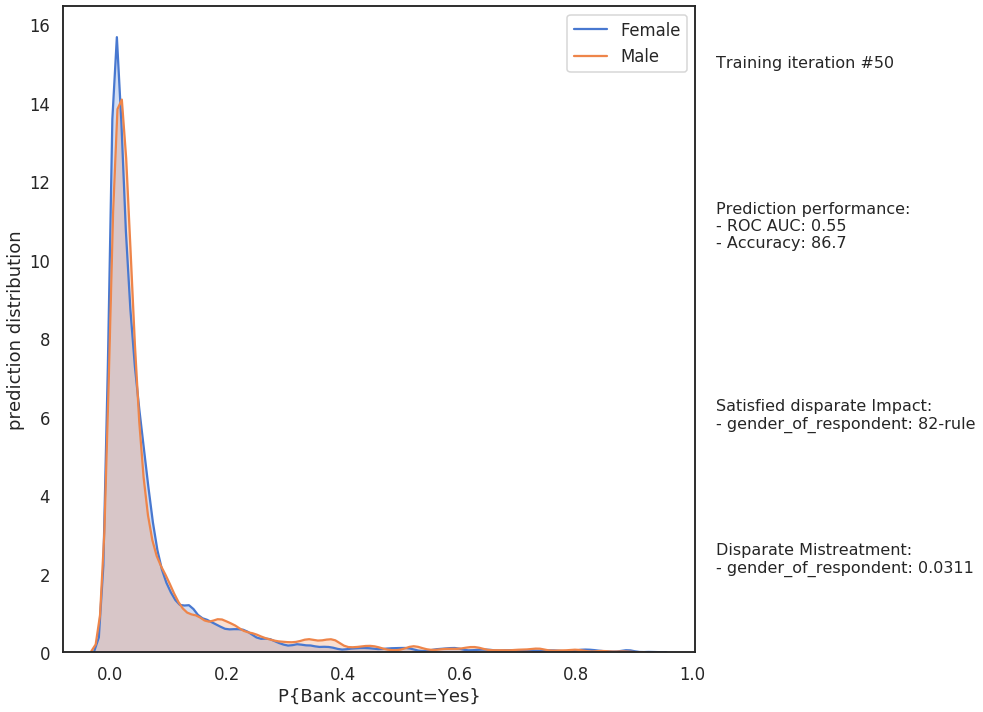

81.9116933527414


In [127]:
clf.fit(X_train, y_train, Z_train, 
        validation_data=(X_test, y_test, Z_test),
        T_iter=50, save_figs=True)


In [128]:
#get predictions
y_pred = clf.predict(X_test)
pred= np.array([int(round(i[0])) for i in y_pred])

In [130]:
#Calculating fairness metric for fair classifier
G=Get_fair_metric('fair',pred,y_test,Z_test)

160 280 160 3522
105 368 186 2277


In [131]:
#visualise
pd.DataFrame([G])

,model,Demographic Parity,Disparate Impact,Equalised_opportunity,Equalised_odds,Treatment equality,Predictive equality,Conditional Use Accuracy,Overall Use Accuracy,ROC Accuracy
0,fair,0.021482,78.325839,0.027896,-0.000626,0.499321,0.000626,-0.07369,0.028522,0.652194


In [146]:
Res =pd.concat([A,B])

In [147]:
T=Res.T

In [148]:
T

,0,0
model,unfair,fair
Demographic Parity,0.048718,0.0214822
Disparate Impact,44.344,78.3258
Equalised_opportunity,-0.101444,0.0278963
Equalised_odds,-0.0182288,-0.00062596
Treatment equality,1.13695,0.499321
Predictive equality,0.0182288,0.00062596
Conditional Use Accuracy,-0.0441926,-0.0736903
Overall Use Accuracy,-0.0832153,0.0285223
ROC Accuracy,0.614912,0.652194
